In [1]:
import re
import numpy as np
import pandas as pd
from contractions import fix

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 100000000

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [2]:
# set file name
filename = "full_paris_emolex"

In [3]:
# reading data
df = pd.read_csv(filename+'.csv', low_memory=False)
df.full_text = df.full_text.apply(str)

# remove URLs from all data
df.full_text = df.full_text.str.replace(r'https?://\S+', '')

# fixing contractions
df.full_text = df.full_text.apply(fix)

# get all text data
data = df['full_text'].copy()

In [4]:
# defining functions to pre-process data, then adding to spacy nlp pipeline
def lemmatizer(doc):
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

def remove_stopwords(doc):
    doc = [token.text for token in doc if (not token.is_stop) and (not token.is_punct)]
    return doc

nlp.add_pipe(lemmatizer, name='lemmatizer', last=True)
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [5]:
# getting documents to process with gensim
doc_list = []
for doc in data:
    if len(doc) > 0:
        pr = nlp(doc)
        doc_list.append(pr)

In [6]:
# get gensim corpora
id2word = corpora.Dictionary(doc_list)

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in doc_list]

In [7]:
# find best model
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, passes=5, per_word_topics=True, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
# setting hyperparameters for coherence value calculations
limit = 15
start = 6
step = 2

In [9]:
# get coherence values for multiple number of topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=doc_list, start=start, limit=limit, step=step)

Num Topics = 6  has Coherence Value of 0.3784
Num Topics = 8  has Coherence Value of 0.3855
Num Topics = 10  has Coherence Value of 0.4142
Num Topics = 12  has Coherence Value of 0.3712
Num Topics = 14  has Coherence Value of 0.376


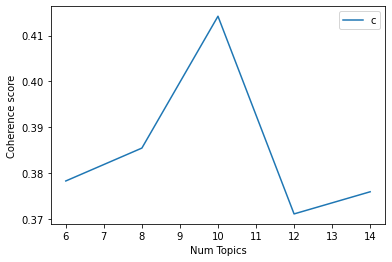

In [10]:
# get plot for best coherence value
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(filename+'_coherence_plot.png')

# print coherence scores for record
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [11]:
# select model and print topics
best_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_model_index]
model_topics = optimal_model.show_topics(formatted=False)
print('OPTIMAL MODEL:')
optimal_model.print_topics(num_topics = -1, num_words=10)

OPTIMAL MODEL:


[(0,
  '0.023*"fuel" + 0.019*"act" + 0.017*"fossil" + 0.017*"withdrawal" + 0.014*"avoid" + 0.014*"international" + 0.014*"stand" + 0.013*"humanity" + 0.013*"reach" + 0.012*"effort"'),
 (1,
  '0.050*"impact" + 0.039*"news" + 0.026*"adapt" + 0.025*"life" + 0.023*"ability" + 0.022*"adverse" + 0.021*"art.2.1(b):increase" + 0.020*"environmental" + 0.018*"administration" + 0.018*"world"'),
 (2,
  '0.180*"global" + 0.092*"warming" + 0.036*"increase" + 0.034*"temperature" + 0.033*"°" + 0.032*"limit" + 0.030*"c" + 0.026*"average" + 0.021*"accord" + 0.019*"set"'),
 (3,
  '0.034*"auspol" + 0.021*"kill" + 0.019*"mid" + 0.017*"run" + 0.016*"miss" + 0.015*"pact" + 0.014*"manage" + 0.014*"ecosystem" + 0.014*"breach" + 0.014*"ratify"'),
 (4,
  '0.052*"new" + 0.031*"meet" + 0.030*"goal" + 0.028*"report" + 0.020*"makeourplanetgreatagain" + 0.017*"find" + 0.017*"major" + 0.014*"fund" + 0.013*"develop" + 0.013*"target"'),
 (5,
  '0.018*"cop23" + 0.018*"man" + 0.017*"tweet" + 0.016*"american" + 0.014*"land

In [12]:
# save topics visualization
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, filename+'_pyldavis.html')